# Churn em instituição financeira fictícia

## Contexto


Este notebook contém o trabalho final da disciplina de Machine Learning para a turma #970 LM Tech Data Talents do curso de Python e Dados da Ada Tech dos alunos:
* Claudia Cavalcante Fonseca
* Hevans Vinícius Pereira
* Lucas Voltolini
* Pedro Henrique Lima Ribeiro
* Renato Massamitsu Zama Inomata
* Vitor Cunha Cavalcanti Manso
* William James Erthal

### O que é churn?

Churn é o comportamento atribuído a um cliente ou funcionário que decide deixar uma empresa.

A importância da análise e churn está ligada à maior dificuldade de conquistar novos clientes se comparada a manter os clientes atuais [[Fonte](https://jrs.digital/conquistar-um-novo-cliente-custa-entre-5-a-7-vezes-mais-que-manter-um-atual/#:~:text=Segundo%20o%20economista%20americano%20Philip,de%20clientes%2C%20usu%C3%A1rios%20e%20compradores.)].

O objetivo desta análise é criar modelos que nos permitam prever quais são os clientes com maior probabilidade de deixar o banco e, se possível, estabelecer os fatores chave que influenciam esses modelos, para auxiliar na criação de campanhas mais efetivas pelo banco.

## Dataset



O dataset está disponível no [Kaggle](https://www.kaggle.com/datasets/shrutimechlearn/churn-modelling).

Ele será usado para a identificação de clientes que deixarão ou não a empresa, ou seja, um problema de classificação binária.

O dataset possui 10 000 registros e 13 colunas:

* **RowNumber**: Coluna indicando o número da linha na tabela de dados.
* **CustomerId**: Número identificador de cada cliente.
* **Surname**: Sobrenome do cliente.
* **CreditScore**: Score de crédito do cliente.
* **Geography**: Indicação de país.
* **Gender**: Sexo do cliente.
* **Age**: Idade do Cliente.
* **Tenure**: Coluna indicando há quanto tempo o cliente está com o banco.
* **Balance**: Coluna indicando o saldo ou o valor associado à conta do cliente.
* **NumOfProducts**: Coluna indicando o número de produtos do banco que o cliente usa.
* **HasCrCard**: Coluna indicando se o cliente possui cartão de crédito (0 ou 1).
* **IsActiveMember**: Coluna indicando se o cliente é ou não ativo (0 ou 1).
* **EstimatedSalary**: Salário estimado do cliente.
* **Exited**: Coluna indicando se o cliente abandonou (1) ou não (0) o banco.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gdown

url = 'https://drive.google.com/uc?id=16QKD3JwUYlMxFvOYJ0buQ5R40Tt9xU4l'
kaggle = 'data_kaggle.csv'

gdown.download(url, kaggle)
df = pd.read_csv(kaggle)
#display(df)
#display(df.head())
display(df.nunique())
#display(df.info())

Downloading...
From: https://drive.google.com/uc?id=16QKD3JwUYlMxFvOYJ0buQ5R40Tt9xU4l
To: c:\Users\Vitor\Documents\visual-code\Curso_Leroy\Módulo 6\data_kaggle.csv
100%|██████████| 685k/685k [00:00<00:00, 1.97MB/s]


RowNumber          10000
CustomerId         10000
Surname             2932
CreditScore          460
Geography              3
Gender                 2
Age                   70
Tenure                11
Balance             6382
NumOfProducts          4
HasCrCard              2
IsActiveMember         2
EstimatedSalary     9999
Exited                 2
dtype: int64

Como cada linha do dataset se refere a um cliente, os campos `RowNumber` e `CustomerId`  são exclusivamente utilizados para contagem e identificação de cada registro e não possuem relação direta com os outros campos do dataset. Portanto, eles são irrelevantes para a tarefa de previsão e podem ser descartados.

Como a coluna `Surname` tem uma grande cardinalidade (uma média de 3,4 pessoas por sobrenome), vamos desconsiderá-la também.

In [2]:
# descartando colunas irrelevantes
df.drop(['RowNumber','CustomerId','Surname'], axis=1, inplace=True, errors='ignore')
print('Restaram as colunas:',list(df.columns))
print('Linhas duplicadas:',df.duplicated().sum())
nulos_por_coluna = df.isnull().sum()
print('Dados nulos:',nulos_por_coluna[nulos_por_coluna != 0])

Restaram as colunas: ['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Exited']
Linhas duplicadas: 0
Dados nulos: Series([], dtype: int64)


Não há linhas duplicadas e nem dados nulos ou NaN em qualquer linha.

## Análise Exploratória de Dados (Univariada)


### Colunas categóricas:
`Geography`,`Gender`,`Tenure`,`NumOfProducts`,`HasCrCard`,`IsActiveMember`

In [3]:
def print_list(lista):
  return ', '.join(' '+str(i)+'('+str(lista[i])+')' for i in lista.index);

colunas_categoricas = ['Geography','Gender','Tenure','NumOfProducts','HasCrCard','IsActiveMember','Exited']
#print(df[colunas_categoricas].nunique())

print('Valores únicos:')
[print(col+":"+print_list(df[col].value_counts())) for col in colunas_categoricas];

Valores únicos:
Geography: France(5014),  Germany(2509),  Spain(2477)
Gender: Male(5457),  Female(4543)
Tenure: 2(1048),  1(1035),  7(1028),  8(1025),  5(1012),  3(1009),  4(989),  9(984),  6(967),  10(490),  0(413)
NumOfProducts: 1(5084),  2(4590),  3(266),  4(60)
HasCrCard: 1(7055),  0(2945)
IsActiveMember: 1(5151),  0(4849)
Exited: 0(7963),  1(2037)


**Percepções:**

* As colunas `Geography`e `NumOfProducts` estão desbalanceadas. Veremos que essas colunas têm alguma relação entre si e com a coluna `Exited`, o nosso alvo.
* As colunas `Gender` e `IsActiveMember` estão relativamente balanceadas.
* As colunas `HasCrCard`, `Exited` estão desbalanceadas. Como nosso objetivo é prever os valores da coluna `Exited`, será **importante balancear a coluna** antes de criarmos nossos modelos, seja com o parâmetro class_weight, Undersampling ou SMOTE, por exemplo.
* A coluna `Tenure` está relativamente balanceada, exceto pelas colunas 0 e 10.

### Colunas numéricas

In [4]:
colunas_numericas=['CreditScore','Age','Balance','EstimatedSalary']
display(df[colunas_numericas].describe().round(2).loc[['min', 'max', 'mean', 'std']])

,CreditScore,Age,Balance,EstimatedSalary
min,350.00,18.00,0.00,11.58
max,850.00,92.00,250898.09,199992.48
mean,650.53,38.92,76485.89,100090.24
std,96.65,10.49,62397.41,57510.49


**Percepções:**

* O salário estimado varia de 11,58 a quase 200.000 o que é um intervalo de variação estranho. É muito provável que o valor mínimo tenha sido digitado errado ou na escala errada (em hora ao invés de ao ano, por exemplo). Vamos plotar um histograma e um boxplot dessa variável para ter um melhor entendimento.
* Todas as demais colunas parecem estar condizentes com dados de clientes de um banco.



________________________________ CreditScore


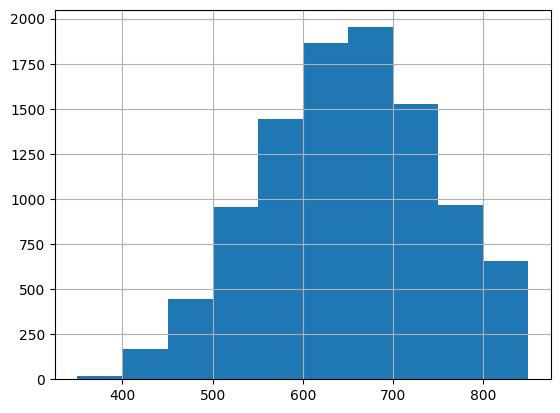

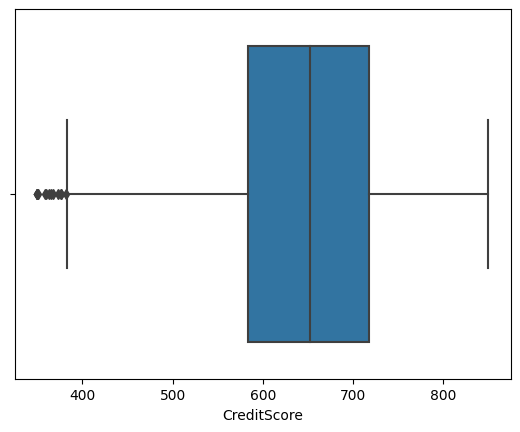

________________________________ Age


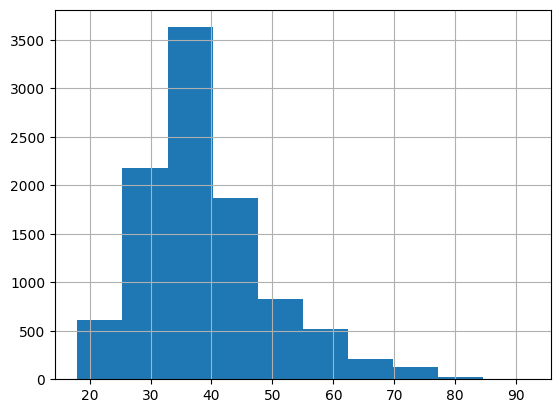

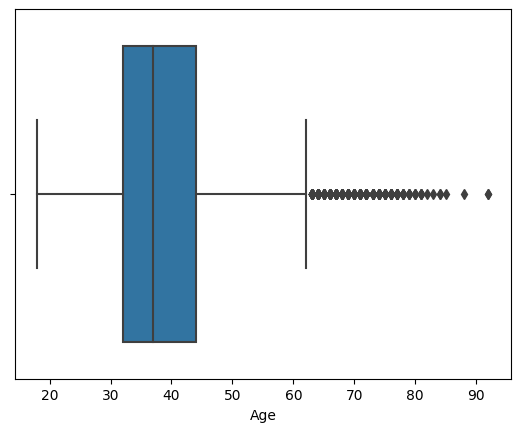

________________________________ Balance


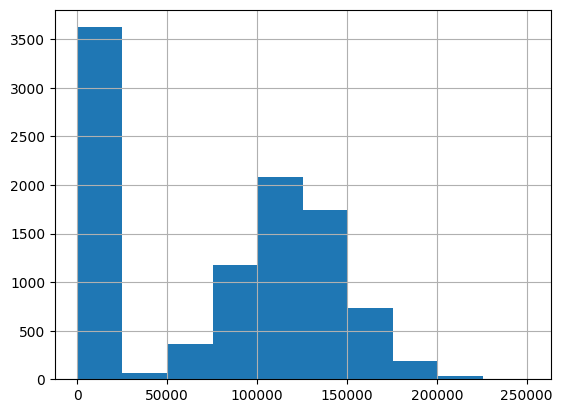

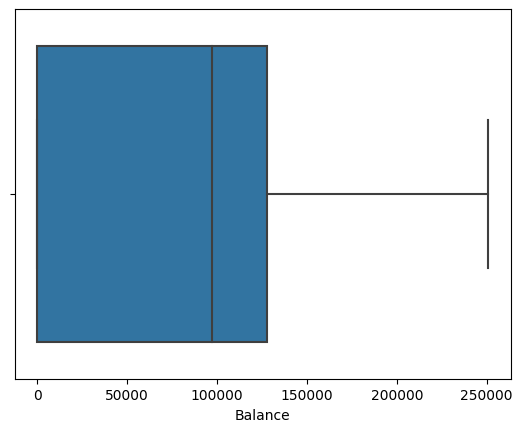

________________________________ EstimatedSalary


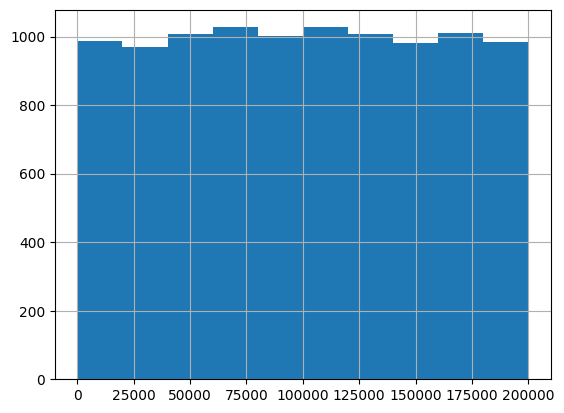

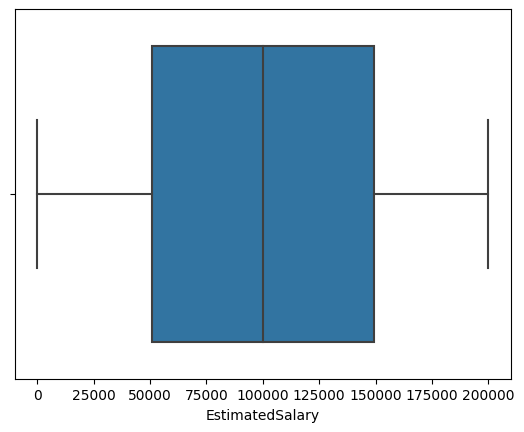

In [5]:
#Verificaremos histogramas e boxplots para as colunas numéricas
for col in colunas_numericas:
  print("_"*32,col)
  df[col].hist()
  plt.show()
  sns.boxplot(df, x=col)
  plt.show()


**Percepções:**

* `EstimatedSalary`: Observando os gráficos acima, podemos ver que a distribuição dessa variável é uniforme, o que é estranho.

* `Age`: Como já era de se esperar, a idade não tem uma distribuição simétrica.

* `Balance`: Há uma quantidade incomum de dados iguais a 0. Isso pode indicar contas que nunca foram utilizadas ou dados incompletos.

**Decisões:**

* Levando em conta que os dados são fictícios e que provavelmente foram gerados de forma sintética, não temos como corrigir ou contestar os dados no salário estimado ou escolher ignorar outliers, então vamos considerar que todos os dados estão corretos e que não há inconsistências.

* Como há muitos registros com o `Balance` igual a 0, vamos tentar criar uma nova variável para diferenciar registros com o balanço nulo e com o balanço positivo. Veremos mais tarde que esta variável exerce influência na variável `Exited` e se relaciona também com a variável `Geography`.

## Análise Exploratória de Dados (Bivariada)

In [6]:
# Como vamos fazer gráficos parecidos,
# vamos criar uma função para comparar as variáveis entre si
def countplot_crosstab(coluna1,coluna2,crosstab=False):
  '''Função para a comparação entre duas colunas categóricas: coluna1 e coluna2.'''
  plt.figure(figsize=(6,3))
  ax = sns.countplot(data=df, x=coluna2, hue=coluna1)
  sns.despine(left=True, bottom=True)
  for label in ax.containers:
      ax.bar_label(label)
  if (crosstab):
    display(pd.crosstab(df[coluna1], df[coluna2]).apply(lambda x: (100*x/(x.sum())).round(2), axis=1))

### Coluna `Exited` X numéricas

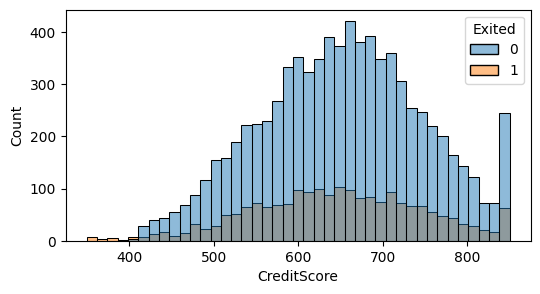

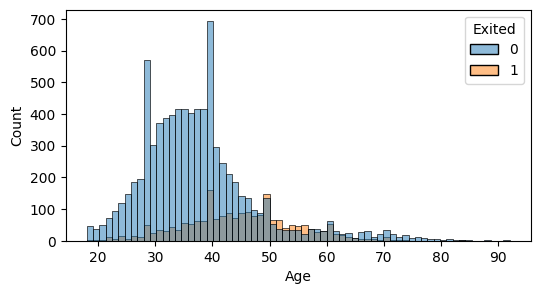

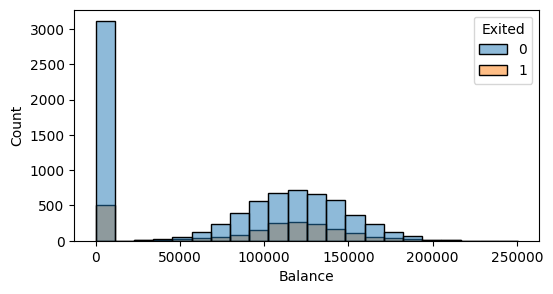

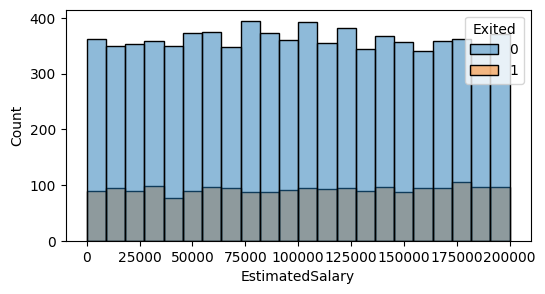

In [7]:
for col in colunas_numericas:
    plt.figure(figsize=(6,3))
    sns.histplot(df, x = col, hue='Exited')
    plt.show()
    #plt.figure(figsize=(6,3))
    #sns.boxplot(df, x='Exited', y=col)
    #plt.show()


**Percepções:**

* `Age`: Vemos que a distribuição dos valores positivos de `Exited` dentro de cada valor da variável `Age` não é proporcional. Assim, é provável que ela seja uma variável importante para o nosso modelo.
* `Balance`: Dentro dos valores positivos de Balance, vemos que a distribuição do `Exited` é proporcional. Porém, nos valores nulos, ela é bem menor. Assim, é provável que uma transformação dessa variável em binária (para valores nulos e positivos) seja benéfica para o modelo. Faremos uma última análise pra tomar essa decisão.

### Coluna `Balance` X categóricas

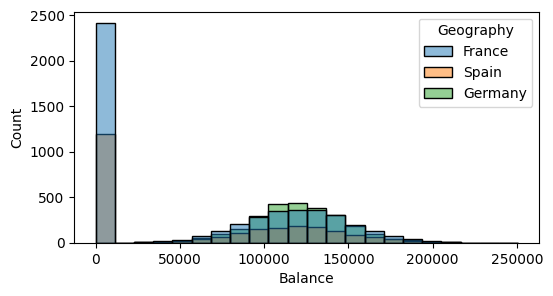

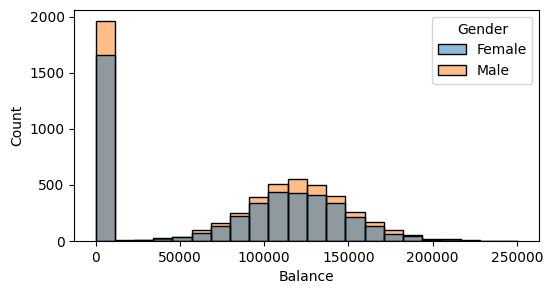

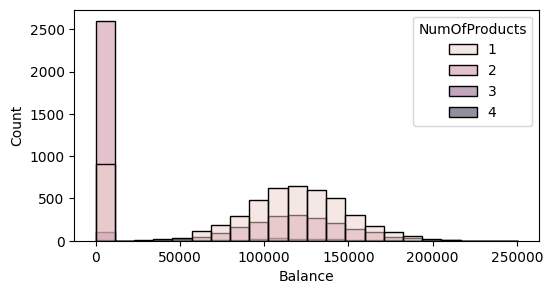

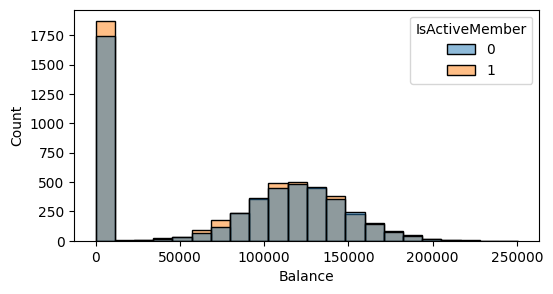

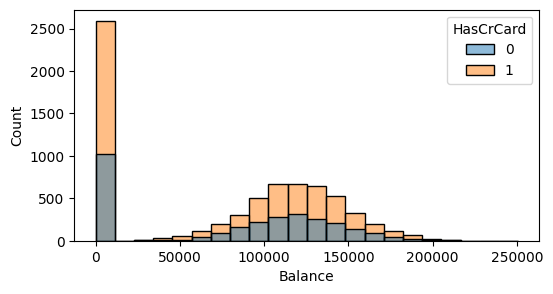

In [8]:
for col in list(set(colunas_categoricas) - set(['Exited','Tenure'])):
    plt.figure(figsize=(6,3))
    sns.histplot(df, x = 'Balance', hue=col)
    plt.show()

**Percepções:**

* A parte positiva da variável `Balance` tem essencialmente o mesmo comportamento dentro de cada grupo das variáveis categóricas.

**Decisão:**

* Assim, optamos por trocá-la por uma variável booleana com 0 para valores nulos de Balance e 1 para valores positivos. Veremos que o comportamento desses dois grupos é diferente para diferentes valores de `Geography`e `NumberOfProducts`.

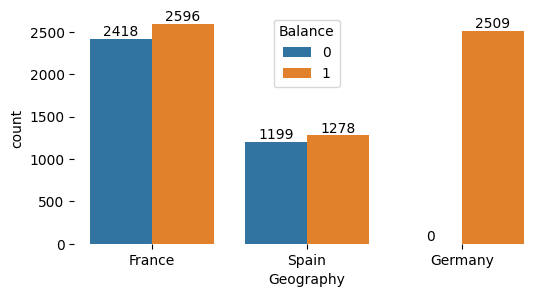

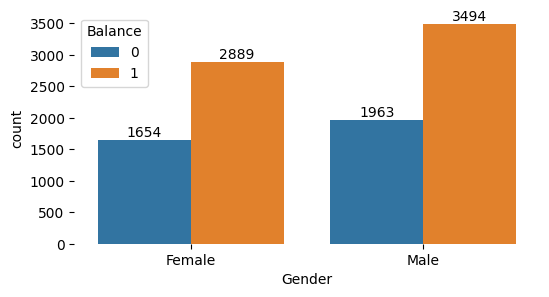

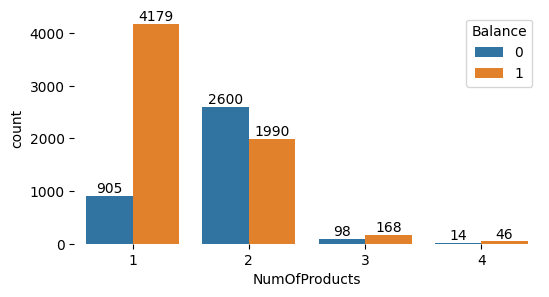

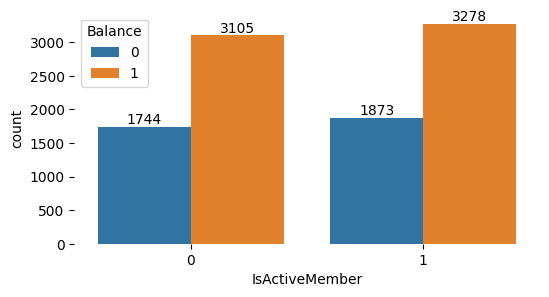

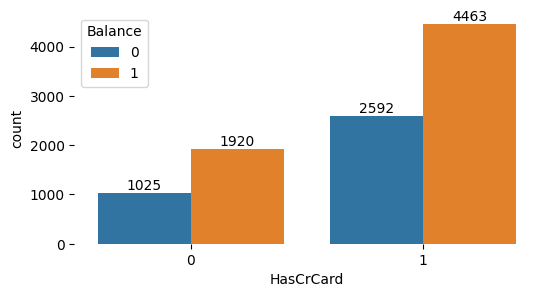

In [9]:
df['Balance'] = [1 if x > 0 else 0 for x in df['Balance']]
#display(df)
for col in list(set(colunas_categoricas) - set(['Exited','Tenure'])):
    countplot_crosstab('Balance',col)
colunas_categoricas.append('Balance')

**Percepções:**

* Vimos que o balanço nulo não tem relação com as contas inativas, como supomos anteriormente.
* Mas, o balanço nulo tem relação com a quantidade de produtos. Em particular, quanto menos produtos, mais pessoas com balanço positivo.
* Por outro lado, todas as pessoas da Alemanha têm balanço positivo, o que pode indicar uma forma de cadastro ou alguma particularidade dos clientes da Alemanha.


### Coluna `Gender` X categóricas

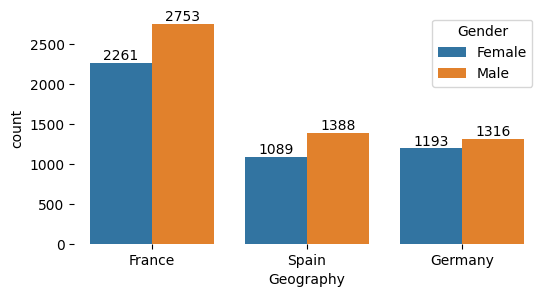

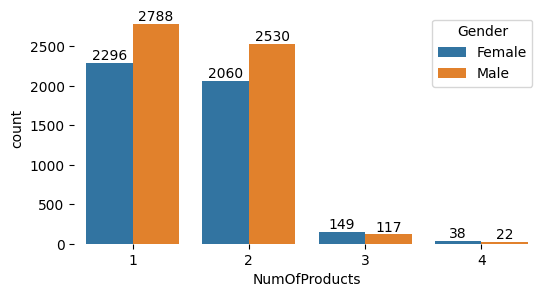

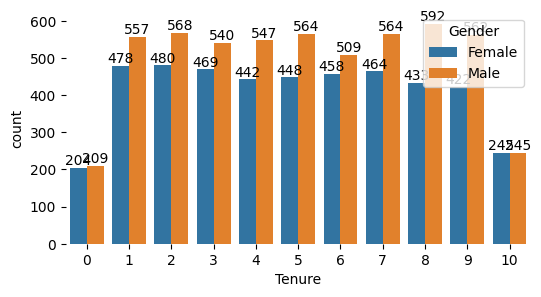

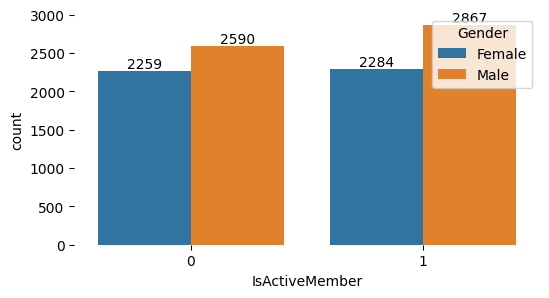

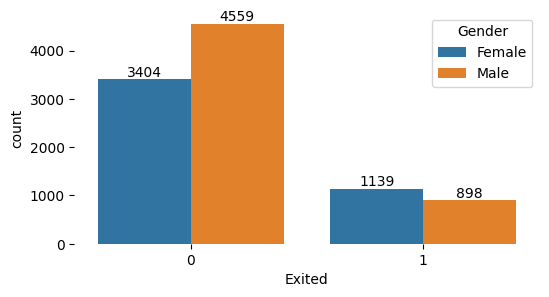

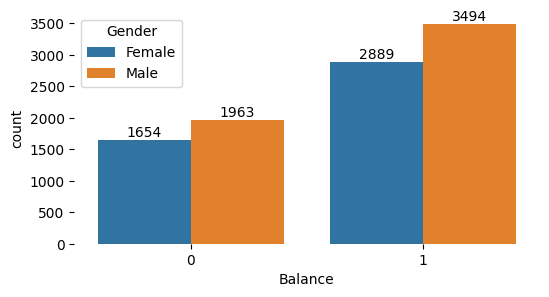

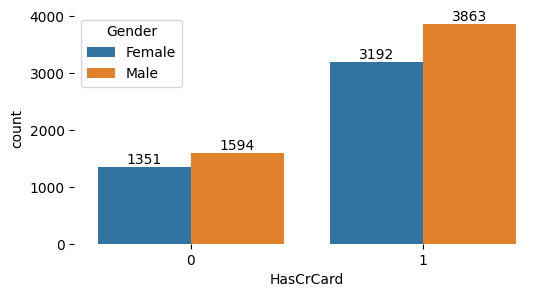

In [10]:
for col in list(set(colunas_categoricas) - set(['Gender'])):
    countplot_crosstab('Gender',col)

**Percepções:**

* O gráfico `NumOfProducts` sugere que mulheres tendem a ter mais produtos, mas como a quantidade de clientes com mais do que 2 produtos é bem pequena, não podemos garantir que isso é um padrão.
* O gráfico `Exited` sugere que mulheres costumam deixar o banco mais do que homens. O que significa que talvez seja interessante criar algumas campanhas de marketing ou promoções voltada a esse público.


### Coluna `Geography` X categóricas

Exited,0,1
Geography,,
France,83.85,16.15
Germany,67.56,32.44
Spain,83.33,16.67


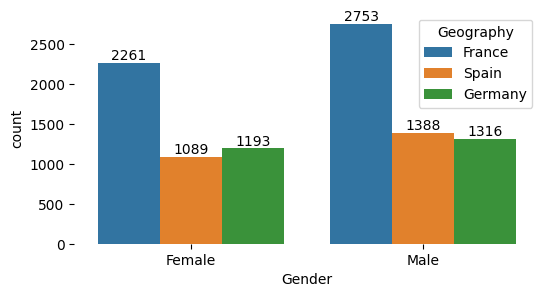

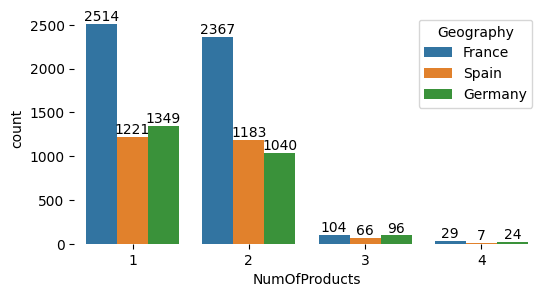

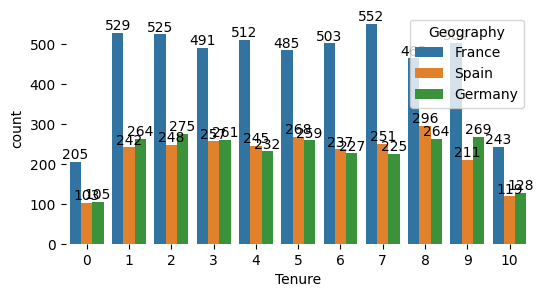

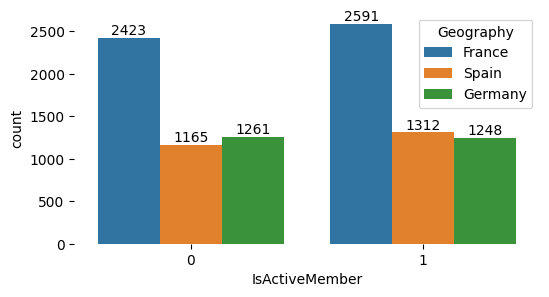

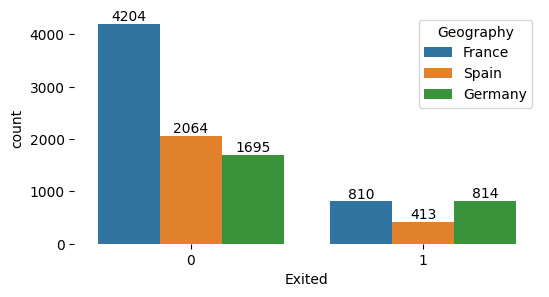

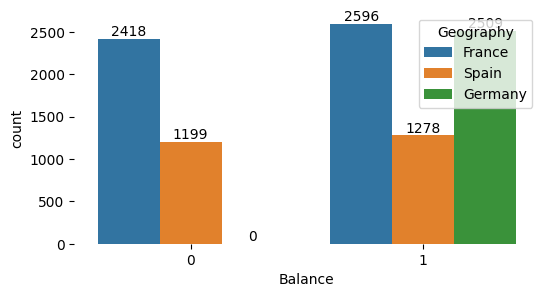

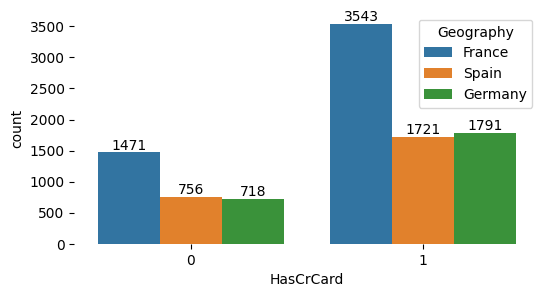

In [11]:
for col in list(set(colunas_categoricas) - set(['Geography'])):
      countplot_crosstab('Geography',col,(col=='Exited'))

**Percepções:**

* Percebemos que, proporcionalmente, a quantidade de alemães que deixam o banco é maior do que a dos outros países, o dobro proporcionalmente.

* Também vemos que a quantidade dos alemães com uma quantidade de produtos diferente de 1 é maior (proporcionalmente) do que a dos outros países. Veremos futuramente que o número de produtos é relevante para a variável `Exited`. Isso poderia sugerir que fosse feita uma análise dos serviços e condições oferecidos na Alemanha comparados aos demais países, dos concorrentes oferecendo serviços apenas na Alemanha e de condições sociais, culturais e políticas que afetem a permanência dos clientes no banco.

Não há pessoas na Alemanha com balanço igual a 0 e há muito mais alemães com mais produtos. Por outro lado, pessoas com balanço diferente de 0 e com mais produtos têm maior probabilidade de sair.

Pensando nisso, hipotetizamos que a propensão de deixar o banco esteja menos ligada com a coluna 'Geography' do que pensamos e que essa diferença entre as pessoas que saem por país seja apenas um reflexo do fato de não termos nenhum alemão com balanço igual a 0 e termos muito mais alemães com uma quantidade de produtos diferente de 2.

Vamos testar nossa hipótese:

In [12]:
df2=df[(df['Balance']==1)&(df['NumOfProducts']>1)]
#print(df2.count()[0]);
display(pd.crosstab(df['Geography'], df['Exited']).apply(lambda x: (100*x/(x.sum())).round(2), axis=1))
display(pd.crosstab(df2['Geography'], df2['Exited']).apply(lambda x: (100*x/(x.sum())).round(2), axis=1))


Exited,0,1
Geography,,
France,83.85,16.15
Germany,67.56,32.44
Spain,83.33,16.67


Exited,0,1
Geography,,
France,79.91,20.09
Germany,79.66,20.34
Spain,74.15,25.85


Isso significa que nossa hipótese pode estar correta. A ligação entre a coluna "Geography", o balanço e o número de produtos provavelmente é bem importante para o cálculo do nosso target.

Uma sugestão que talvez ajude no nosso modelo é colocar a quantidade de produtos como uma coluna categórica com o one-hot encoding (talvez apenas com duas colunas: 1 produto e 2 produtos).





### Coluna `NumOfProducts` X categóricas

Exited,0,1
NumOfProducts,,
1,72.29,27.71
2,92.42,7.58
3,17.29,82.71
4,0.00,100.00


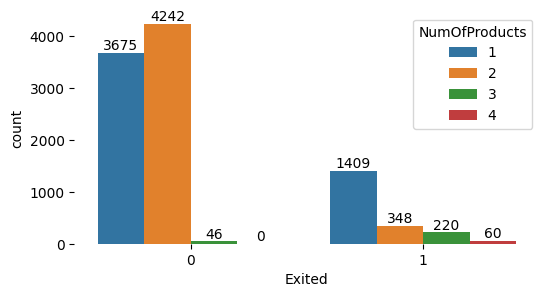

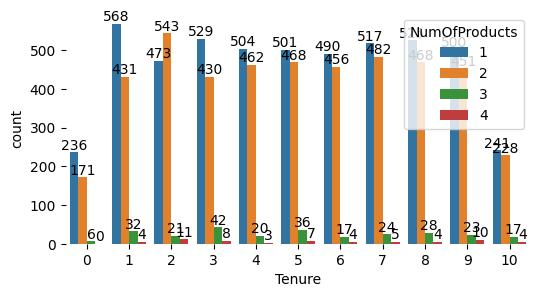

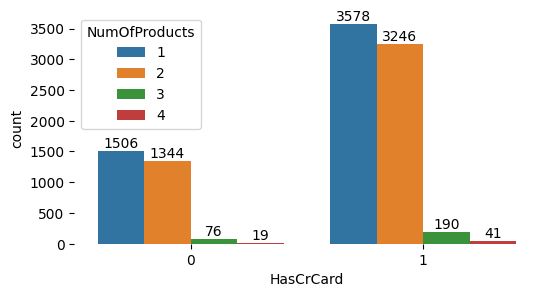

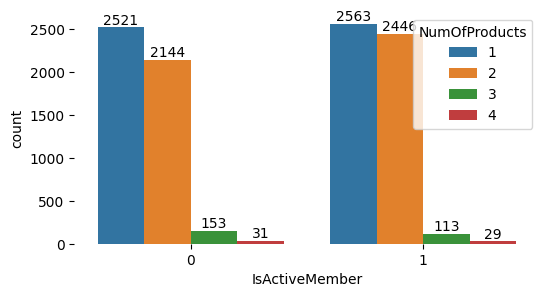

In [13]:
for col in list(set(colunas_categoricas) - set(['NumOfProducts','Gender','Balance','Geography'])):
      countplot_crosstab('NumOfProducts', col, (col=='Exited'))

**Percepções:**

* Comparando a coluna `Exited` com a `NumOfProducts`, a quantidade de produtos ideal para os clientes são 2 produtos. Em geral, clientes com 1 produto são um pouco mais suscetíveis a sair e com 3 ou 4 são muito mais suscetíveis. Talvez isso se dê por conta do tipo de produto e não da quantidade. Seria interessante ter acesso a esses dados para tomar decisões mais específicas.

## Correlação entre as variáveis

Algumas das variáveis são categóricas, portanto usaremos o coeficiente de correlação de Spearman para verificar se há correlação entre as variáveis.

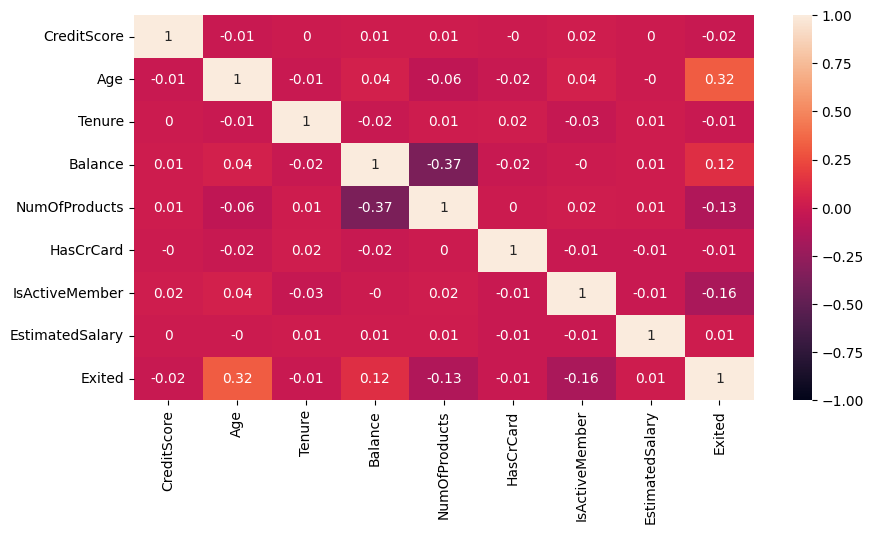

In [14]:
# calculando correlação entre as variáveis
colunas = ['CreditScore','Age','Tenure','Balance','NumOfProducts',
           'HasCrCard','IsActiveMember','EstimatedSalary','Exited']

plt.figure(figsize=(10,5))
sns.heatmap(df[colunas].corr(method='spearman').round(2), vmin=-1, vmax=1, annot=True);

# Machine Learning

## Métricas

Consideramos a possibilidade de utilizar o recall como métrica, penalizando mais os falso negativos que os falso positivos, visto que o custo para manter um cliente é menor que para conseguir novos clientes.

Porém, esse custo deve ser gerenciado pelo próprio negócio. Em particular, o banco provavelmente tem uma função de métrica própria que leva em consideração esses custos e riscos e essa métrica deveria ser levada em conta.

Como nosso banco é fictício, buscamos um equilíbrio e escolhemos a métrica f1-score.

## Modelagem

Para a modelagem, é importante lembrar que o dataset é desbalanceado. Dessa maneira, alguns métodos devem ser aplicados a fim de contornar os problemas inerentes deste desbalanceamento.

Criamos uma pipeline para o modelo, que passará pelas seguintes etapas:

* Train/Test split, com o método _stratify_;
* Aplicação de métodos de balanceamento de classes, com `RandomUnderSample`, `SMOTE` ou utilização do parâmetro `class_weights` dos classificadores;
* Aplicação de técnicas para o _scaling_ do conjunto de dados, neste caso `StandardScaler` e `MinMaxScaler` (também realizamos testes sem o _scaling_ dos dados);
* Instanciamento do método de classificação, que para este trabalho foram `LogisticRegression`, `DecisionTreeClassifier` e `RandomForestClassifier`;
* Utilização de um K-fold para fazer a validação cruzada dos dados, o `StratifiedKFold`;
* Utilização de um algoritmo para seleção dos hiperpârametros, neste caso foi utilizado o `RandomizedSearchCV` com um range de hiperparâmetros previamente estabelecidos para cada classificador.

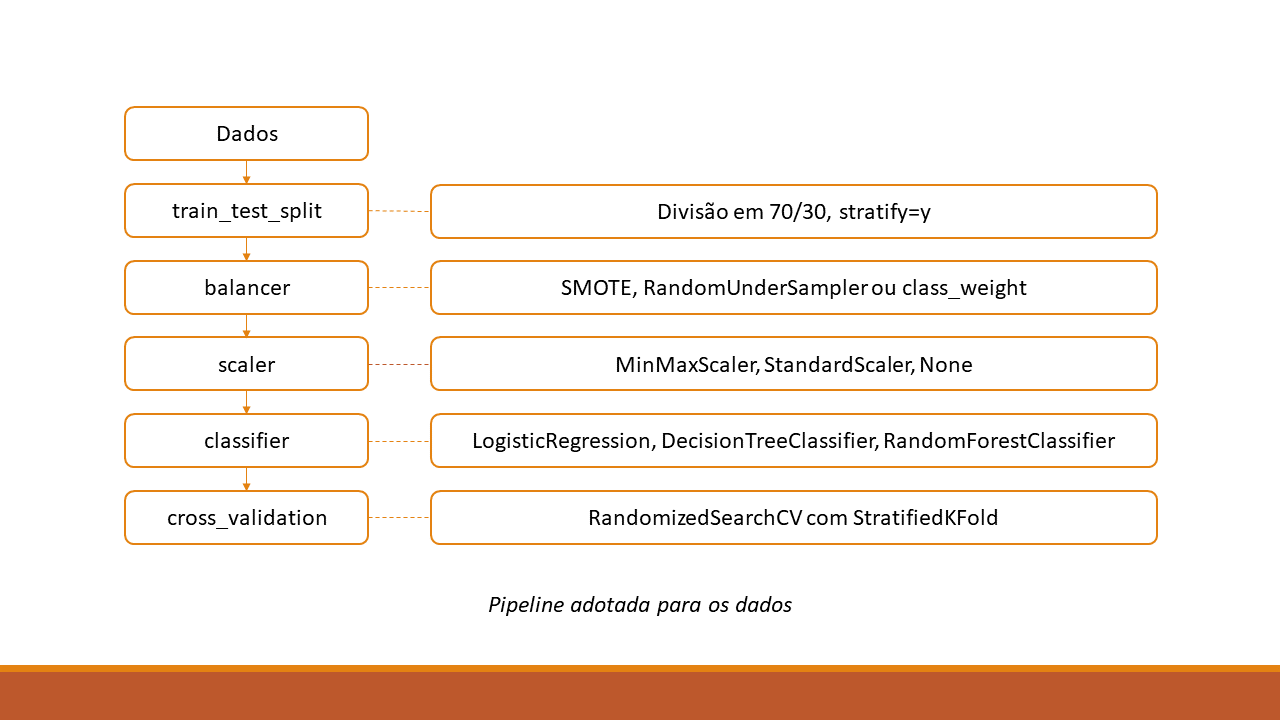

A seguir, a classe e métodos para criar e avaliar os diferentes modelos.

In [17]:
# Modelo

import pandas as pd
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as imbpipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_auc_score

class Modelo():

    def __init__(self, df):
        self.df = df

    def gerar_modelo(self, balancer, scaler, classifier, params=None, random_state=31, refit='f1'):

        X = self.df.drop(columns='Exited')
        y = self.df.Exited

        X_train, X_test, y_train, y_test = train_test_split(X,
                                                            y,
                                                            test_size=0.3,
                                                            stratify=y,
                                                            random_state=random_state)

        # Criando passos para a pipeline
        pipe_steps = []

        # Balancer
        if balancer == 'SMOTE':
            pipe_steps.append(
                ('balancer', SMOTE(random_state=random_state)),
                )
        elif balancer == 'RandomUnderSampler':
            pipe_steps.append(
                ('balancer', RandomUnderSampler(random_state=random_state))
            )

        # Scaler
        if scaler == 'MinMaxScaler':
            pipe_steps.append(
                ('scaler', MinMaxScaler()),
            )
        elif scaler == 'StandardScaler':
            pipe_steps.append(
                ('scaler', StandardScaler()),
            )

        # Classifier
        if classifier == 'LogisticRegression':
            pipe_steps.append(
                ('classifier', LogisticRegression(random_state=random_state,
                                                  class_weight='balanced',
                                                  ))
            )

        elif classifier == 'DecisionTreeClassifier':
            pipe_steps.append(
                ('classifier', DecisionTreeClassifier(random_state=random_state,
                                                      class_weight='balanced'
                                                    # criterion='gini',
                                                    # max_features='sqrt',
                                                    ))
            )
        elif classifier == 'RandomForestClassifier':
            pipe_steps.append(
                ('classifier', RandomForestClassifier(random_state=random_state,
                                                      n_jobs=-1,
                                                      class_weight='balanced',
                                                      ))
            )

        # params
        if params == None:

            if classifier == 'LogisticRegression':
                params = {
                    'classifier__C': [.001, .01, .1, 1, 10, 100, 1000],
                    }

            elif classifier == 'DecisionTreeClassifier':
                params = {
                    'classifier__max_depth': [3, 4, 5, 6, 7, 8],
                    'classifier__max_features':['sqrt', 'log2'],
                    'classifier__criterion': ['gini', 'entropy', 'log_loss'],
                    }

            elif classifier == 'RandomForestClassifier':
                params = {
                    'classifier__max_depth': [3, 4, 5, 6, 7, 8],
                    'classifier__max_features':['sqrt', 'log2'],
                    'classifier__criterion': ['gini', 'entropy', 'log_loss'],
                    'classifier__n_estimators': [5, 10, 25, 50, 100],
                    }
            elif classifier == 'MLPClassifier':
                params = {
                    'classifier__activation': ['relu', 'logistic'],
                    'classifier__alpha': [0.01, 0.1, 1, 10],
                    'classifier__hidden_layer_sizes': [1, 5, 10, 25, 50]
                }

        pipeline = imbpipeline(pipe_steps)

        stratified_kfold = StratifiedKFold(n_splits = 5,
                                           shuffle=True,
                                           random_state=random_state)

        search = RandomizedSearchCV(estimator=pipeline,
                                    param_distributions=params,
                                    refit=refit,
                                    scoring=('f1',
                                            'roc_auc',
                                            'accuracy',
                                            'precision',
                                            'recall',
                                            ),
                                    cv=stratified_kfold,
                                )

        search.fit(X_train, y_train)

        y_pred = search.predict(X_test)

        self.X = X
        self.y = y
        self.modelo = search
        self.X_test = X_test
        self.X_train = X_train
        self.y_test = y_test
        self.y_train = y_train
        self.y_pred = y_pred
        self.best_params_ = search.best_params_

        cv_results = search.cv_results_

        cv_results['balancer'] = balancer
        cv_results['scaler'] = scaler
        cv_results['classifier'] = classifier

        self.cv_results = cv_results

        self.cm = confusion_matrix(y_test, y_pred)

        scores_modelo = {
            'f1_score': [f1_score(self.y_test, self.y_pred)],
            'roc_auc_score': [roc_auc_score(self.y_test, self.y_pred)],
            'accuracy_score': [accuracy_score(self.y_test, self.y_pred)],
            'precision_score': [precision_score(self.y_test, self.y_pred)],
            'recall_score': [recall_score(self.y_test, self.y_pred)],
            }

        self.scores = pd.DataFrame(scores_modelo)

        return search

    # gráfico da curva roc
    def curva_roc(self):
        logit_roc_auc = roc_auc_score(self.y_test, self.y_pred)
        fpr, tpr, thresholds = roc_curve(self.y_test, self.modelo.predict_proba(self.X_test)[:,1])
        plt.figure(figsize=(4,2))
        plt.plot(fpr, tpr, label=f'(área = {round(logit_roc_auc, 2)})')
        plt.plot([0, 1], [0, 1],'r--')
        plt.xlabel('Taxa de Falso Positivo')
        plt.ylabel('Taxa de Verdadeiro Positivo')
        plt.title('Curva ROC')
        plt.legend(loc="lower right");


    # calculando a importância das variáveis
    def importancia_variaveis(self):
        result = permutation_importance(
            self.modelo, self.X_test, self.y_test, n_repeats=10, random_state=42, n_jobs=2, scoring='f1'
        )

        sorted_importances_idx = result['importances_mean'].argsort()
        importances = pd.DataFrame(
            result.importances[sorted_importances_idx].T,
            columns=self.X.columns[sorted_importances_idx],
        )

        ax = importances.plot.box(vert=False, whis=10)
        ax.set_title("Importância das Permutações em Validação")
        ax.axvline(x=0, color="k", linestyle="--")
        ax.set_xlabel("Decaimento no f1")
        ax.figure.tight_layout()


Criamos também algumas funções para salvar logs com os resultados dos cross-validations (através do método `cv_results_`) e também os resultados dos melhores hiperparâmetros.

In [18]:
# Função para gerar logs dos resultados do Cross-Validation
def gerar_logs_CV(df, comb, refit='f1'):

    modelo = Modelo(df)
    # print('df', modelo.df)
    log_CV = pd.DataFrame()
    log_best_params = pd.DataFrame()

    for balancer, scaler, classifier in comb:
        print(f'balancer {balancer} - scaler {scaler} - classifier {classifier}')
        modelo.gerar_modelo(balancer=balancer, scaler=scaler, classifier=classifier, refit=refit)
        cv_results = pd.DataFrame(modelo.cv_results)
        log_CV = pd.concat([log_CV, cv_results])

        # Adicionando informações aos resultados do cv_results_
        cv_results['metrica'] = refit # a métrica escolhida para definir o melhor parâmetro
        cv_results['f1_score'] = f1_score(modelo.y_test, modelo.y_pred)
        cv_results['recall_score'] = recall_score(modelo.y_test, modelo.y_pred)
        cv_results['precision_score'] = precision_score(modelo.y_test, modelo.y_pred)
        cv_results['accuracy_score'] = accuracy_score(modelo.y_test, modelo.y_pred)
        cv_results['roc_auc_score'] = roc_auc_score(modelo.y_test, modelo.y_pred)

        # Log com apenas o resultado do melhor parâmetro
        log_best_params = pd.concat([log_best_params, cv_results[cv_results.params == modelo.best_params_]])

    # Criar uma coluna com as variáveis usadas para o teste
    log_CV['variaveis_df'] = [df.columns.to_list() for _ in range(log_CV.shape[0])]
    log_best_params['variaveis_df'] = [df.columns.to_list() for _ in range(log_best_params.shape[0])]

    return log_CV, log_best_params

Faremos a análise de todas as combinações dos métodos mencionados na seção da modelagem, totalizando 27 diferentes combinações.

In [19]:
# Os testes serão feitos pela combinação dos seguintes itens:
balancers = ['SMOTE', 'RandomUnderSampler', 'class_weight']
scalers = ['MinMaxScaler', 'StandardScaler', 'None']
classifiers = ['LogisticRegression', 'DecisionTreeClassifier', 'RandomForestClassifier',]

from itertools import product

comb = list(product(balancers, scalers, classifiers))

As funções a seguir referem-se às visualizações dos resultados dos testes.

In [20]:
def score_matrix(log_best_params):
   score_matrix = log_best_params.loc[:, ['classifier', 'balancer', 'scaler',
                                          'f1_score', 'mean_test_f1',
                                          'roc_auc_score', 'mean_test_roc_auc',
                                          'accuracy_score', 'mean_test_accuracy',
                                          'precision_score', 'mean_test_precision',
                                          'recall_score', 'mean_test_recall',
                                          ]].set_index(['classifier', 'balancer', 'scaler']).sort_index()

   plt.figure(figsize=(10,7))
   sns.heatmap(score_matrix, annot=True, vmin=0, vmax=1, )
   plt.show()

   return score_matrix

def time_matrix(log_best_params):
   time_matrix = log_best_params.loc[:, ['classifier', 'balancer', 'scaler',
                                       'mean_fit_time', 'mean_score_time',
                                       ]].set_index(['classifier', 'balancer', 'scaler']).sort_index()

   plt.figure(figsize=(10,7))
   sns.heatmap(time_matrix, annot=True, cmap=sns.cm.rocket_r)
   plt.show()
   return time_matrix

## Testes

### Teste 1
Consideramos as seguintes informações para o primeiro teste.

Variáveis utilizadas:

    ['CreditScore', 'Age', 'Tenure', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Geography_Germany',
       'Geography_Spain', 'Gender_Male', 'HasBalance', 'Exited'],

Métrica utilizada para análise:

    f1

In [21]:
#Lendo o arquivo csv novamente para obter os dados brutos
dados_brutos = pd.read_csv(kaggle)

In [22]:
# Testes com df1

# Gerando dummies de Geography e Gender
# Removemos uma das colunas para evitar problemas de colinearidade
df1 = pd.get_dummies(dados_brutos, columns=['Geography', 'Gender'], drop_first=True)
# Removendo colunas desncessárias para a análise
df1 = df1.drop(columns=['RowNumber', 'CustomerId', 'Surname'])
# Substituindo a coluna numérica de Balance por sua versão booleana
df1['HasBalance'] = np.where(df1.Balance > 0, 1, 0)
df1.drop(columns='Balance', inplace=True)

# Passar 'Exited' como última coluna
col_last = ['Exited']
df1 = df1[[col for col in df1 if col not in col_last] + col_last]

In [23]:
nome_teste = 'df1'
refit = 'f1'
# Gerando o log para o df1
logCV_df1_f1, logBestParams_df1_f1 = gerar_logs_CV(df=df1, comb=comb, refit=refit)

# path_logCV_df1_f1 = './logCV' + '_' + nome_teste + '_' + refit + '.csv'
# path_logBestParams_df1_f1 = './logBestParams' + '_' + nome_teste + '_' + refit + '.csv'

# Salvando os logs em csv
# logCV_df1_f1.to_csv(path_logCV_df1_f1, sep=';', decimal=',')
# logBestParams_df1_f1.to_csv(path_logBestParams_df1_f1, sep=';', decimal=',')

balancer SMOTE - scaler MinMaxScaler - classifier LogisticRegression


C:\Users\lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_search.py:305: UserWarning: The total space of parameters 7 is smaller than n_iter=10. Running 7 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


balancer SMOTE - scaler MinMaxScaler - classifier DecisionTreeClassifier
balancer SMOTE - scaler MinMaxScaler - classifier RandomForestClassifier
balancer SMOTE - scaler StandardScaler - classifier LogisticRegression


C:\Users\lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_search.py:305: UserWarning: The total space of parameters 7 is smaller than n_iter=10. Running 7 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


balancer SMOTE - scaler StandardScaler - classifier DecisionTreeClassifier
balancer SMOTE - scaler StandardScaler - classifier RandomForestClassifier
balancer SMOTE - scaler None - classifier LogisticRegression


C:\Users\lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_search.py:305: UserWarning: The total space of parameters 7 is smaller than n_iter=10. Running 7 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
C:\Users\lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\lucas\AppData\Local\Packages\PythonSoftwareFound

balancer SMOTE - scaler None - classifier DecisionTreeClassifier
balancer SMOTE - scaler None - classifier RandomForestClassifier
balancer RandomUnderSampler - scaler MinMaxScaler - classifier LogisticRegression


C:\Users\lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_search.py:305: UserWarning: The total space of parameters 7 is smaller than n_iter=10. Running 7 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


balancer RandomUnderSampler - scaler MinMaxScaler - classifier DecisionTreeClassifier
balancer RandomUnderSampler - scaler MinMaxScaler - classifier RandomForestClassifier
balancer RandomUnderSampler - scaler StandardScaler - classifier LogisticRegression


C:\Users\lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_search.py:305: UserWarning: The total space of parameters 7 is smaller than n_iter=10. Running 7 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


balancer RandomUnderSampler - scaler StandardScaler - classifier DecisionTreeClassifier
balancer RandomUnderSampler - scaler StandardScaler - classifier RandomForestClassifier
balancer RandomUnderSampler - scaler None - classifier LogisticRegression


C:\Users\lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_search.py:305: UserWarning: The total space of parameters 7 is smaller than n_iter=10. Running 7 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
C:\Users\lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


balancer RandomUnderSampler - scaler None - classifier DecisionTreeClassifier
balancer RandomUnderSampler - scaler None - classifier RandomForestClassifier
balancer class_weight - scaler MinMaxScaler - classifier LogisticRegression


C:\Users\lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_search.py:305: UserWarning: The total space of parameters 7 is smaller than n_iter=10. Running 7 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


balancer class_weight - scaler MinMaxScaler - classifier DecisionTreeClassifier
balancer class_weight - scaler MinMaxScaler - classifier RandomForestClassifier
balancer class_weight - scaler StandardScaler - classifier LogisticRegression


C:\Users\lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_search.py:305: UserWarning: The total space of parameters 7 is smaller than n_iter=10. Running 7 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


balancer class_weight - scaler StandardScaler - classifier DecisionTreeClassifier
balancer class_weight - scaler StandardScaler - classifier RandomForestClassifier
balancer class_weight - scaler None - classifier LogisticRegression


C:\Users\lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_search.py:305: UserWarning: The total space of parameters 7 is smaller than n_iter=10. Running 7 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


balancer class_weight - scaler None - classifier DecisionTreeClassifier
balancer class_weight - scaler None - classifier RandomForestClassifier


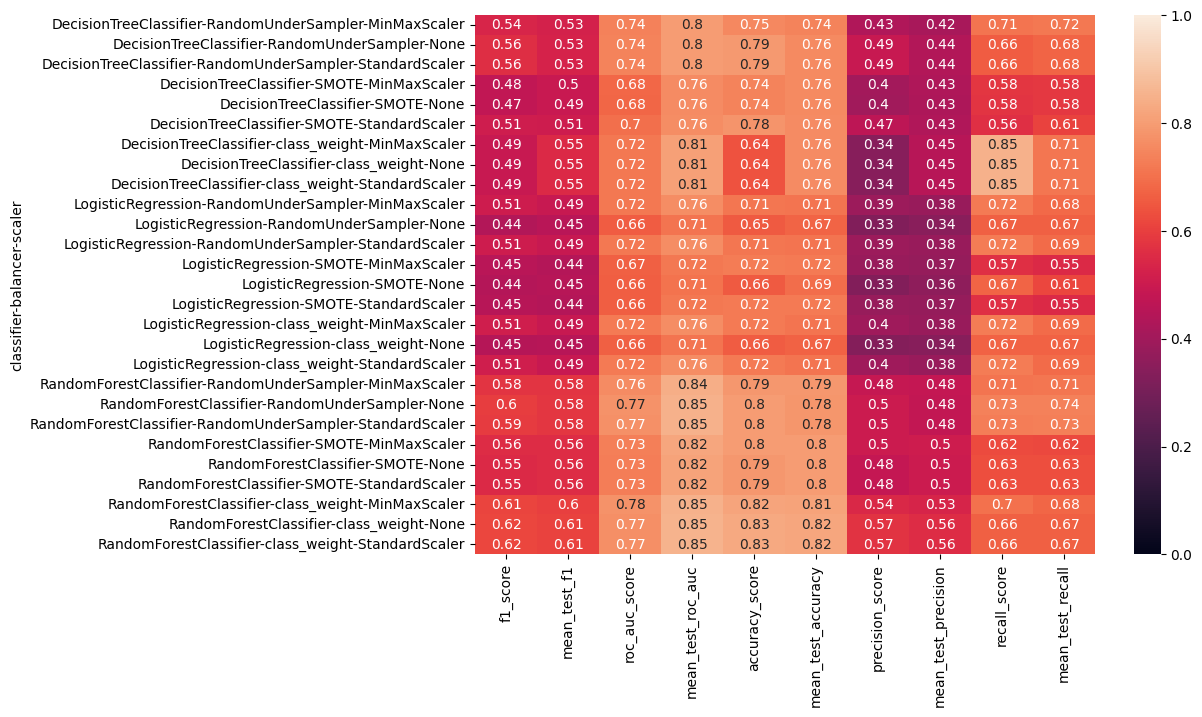

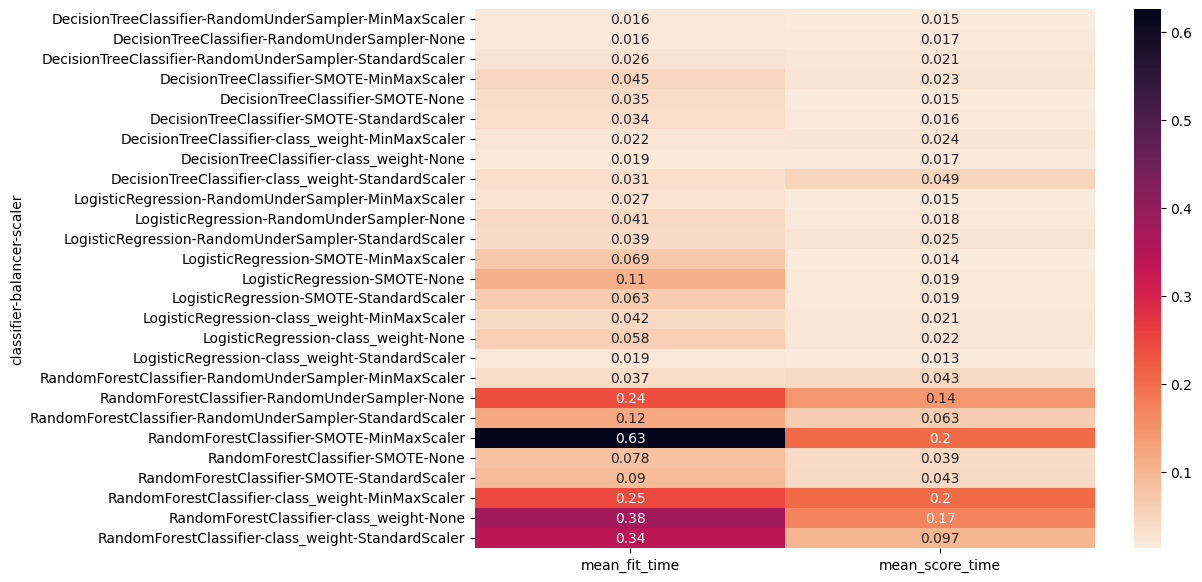

mean_fit_time  \
classifier             balancer           scaler                          
DecisionTreeClassifier RandomUnderSampler MinMaxScaler         0.015958   
                                          None                 0.015740   
                                          StandardScaler       0.025821   
                       SMOTE              MinMaxScaler         0.045332   
                                          None                 0.035046   
                                          StandardScaler       0.034015   
                       class_weight       MinMaxScaler         0.021753   
                                          None                 0.019169   
                                          StandardScaler       0.030591   
LogisticRegression     RandomUnderSampler MinMaxScaler         0.027468   
                                          None                 0.040964   
                                          StandardScaler       0.038939   
                       SMOTE              MinMaxScaler         0.069430   
                                          None                 0.105945   
                                          StandardScaler       0.062745   
                       class_weight       MinMaxScaler         0.041877   
                                          None                 0.057700   
                                          StandardScaler       0.019411   
RandomForestClassifier RandomUnderSampler MinMaxScaler         0.036888   
                                          None                 0.239118   
                                          StandardScaler       0.116316   
                       SMOTE              MinMaxScaler         0.625557   
                                          None                 0.078340   
                                          StandardScaler       0.089847   
                       class_weight       MinMaxScaler         0.246456   
                                          None                 0.376252   
                                          StandardScaler       0.340591   

                                                          mean_score_time  
classifier             balancer           scaler                           
DecisionTreeClassifier RandomUnderSampler MinMaxScaler           0.015318  
                                          None                   0.016508  
                                          StandardScaler         0.020532  
                       SMOTE              MinMaxScaler           0.023307  
                                          None                   0.015076  
                                          StandardScaler         0.016364  
                       class_weight       MinMaxScaler           0.023647  
                                          None                   0.016900  
                                          StandardScaler         0.048656  
LogisticRegression     RandomUnderSampler MinMaxScaler           0.014917  
                                          None                   0.018343  
                                          StandardScaler         0.025495  
                       SMOTE              MinMaxScaler           0.013664  
                                          None                   0.018677  
                                          StandardScaler         0.018671  
                       class_weight       MinMaxScaler           0.020651  
                                          None                   0.022357  
                                          StandardScaler         0.013067  
RandomForestClassifier RandomUnderSampler MinMaxScaler           0.042662  
                                          None                   0.143116  
                                          StandardScaler         0.063170  
                       SMOTE              MinMaxScaler           0.204076  
                                          None            

In [24]:
score_matrix(logBestParams_df1_f1)
time_matrix(logBestParams_df1_f1)

Dos modelos gerados, um dos melhores foi:
* classifier: RandomForestClassifier
* balancer: class_weight
* scaler: None

Vamos verificar como se comportaram os resultados para este modelo

In [25]:
# Gerando o modelo
modelo1 = Modelo(df1)
modelo1.gerar_modelo(balancer='class_weight', scaler='None', classifier='RandomForestClassifier', refit='f1')

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=31, shuffle=True),
                   estimator=Pipeline(steps=[('classifier',
                                              RandomForestClassifier(class_weight='balanced',
                                                                     n_jobs=-1,
                                                                     random_state=31))]),
                   param_distributions={'classifier__criterion': ['gini',
                                                                  'entropy',
                                                                  'log_loss'],
                                        'classifier__max_depth': [3, 4, 5, 6, 7,
                                                                  8],
                                        'classifier__max_features': ['sqrt',
                                                                     'log2'],
                                        'classifier__n_estimators': [5, 10, 25,
                                                                     50, 100]},
                   refit='f1',
                   scoring=('f1', 'roc_auc', 'accuracy', 'precision', 'recall'))

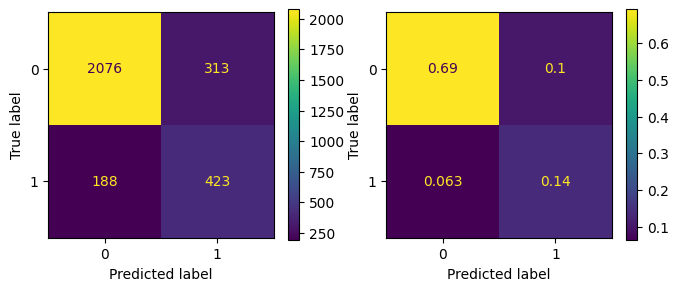

In [26]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))
ConfusionMatrixDisplay(modelo1.cm).plot(ax=ax1)
ConfusionMatrixDisplay(modelo1.cm / modelo1.cm.sum()).plot(ax=ax2)

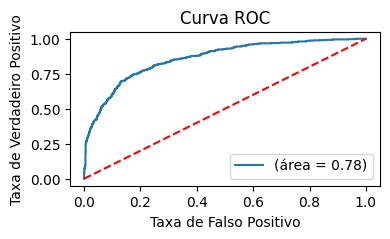

In [27]:
from sklearn.metrics import roc_curve
modelo1.curva_roc()

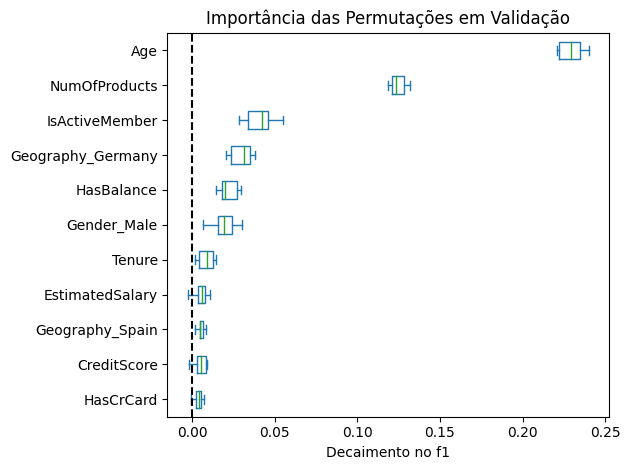

In [28]:
from sklearn.inspection import permutation_importance

modelo1.importancia_variaveis()

#### Considerações

É interessante notar que a ausência de um _scaler_ não afetou os resultados do modelo, uma vez que o algoritmo utilizado é baseado em árvores de decisão.

Para a importância das variáveis, as colunas de `Age` e `NumOfProducts` foram as que mais importantes para o modelo, assim como o verificado na etapa de Análise Exploratória de Dados.

### Teste 2

Para o segundo teste resolvemos categorizar a coluna `Age` agrupando ela pelas dezenas das idades, e também criamos uma nova feature `HasLotsOfProducts` que retorna 1 para os clientes com mais de 2 produtos e 0 para os demais.

Variáveis utilizadas:

    ['CreditScore', 'Tenure', 'NumOfProducts', 'HasCrCard', 'IsActiveMember',
    'EstimatedSalary', 'Geography_Germany', 'Geography_Spain',
    'Gender_Male', 'HasBalance', 'HasLotsOfProducts', 'GroupAge_20',
    'GroupAge_30', 'GroupAge_40', 'GroupAge_50', 'GroupAge_60',
    'GroupAge_70', 'GroupAge_80', 'GroupAge_90', 'Exited']

Métrica utilizada para análise:

    f1

In [29]:
# Testes com df2

# Gerando dummies de Geography e Gender
# Removemos uma das colunas para evitar problemas de colinearidade
df2 = pd.get_dummies(dados_brutos, columns=['Geography', 'Gender'], drop_first=True)
# Removendo colunas desncessárias para a análise
df2 = df2.drop(columns=['RowNumber', 'CustomerId', 'Surname'])

# Substituindo a coluna numérica de Balance por sua versão booleana
df2['HasBalance'] = np.where(df2.Balance > 0, 1, 0)
df2.drop(columns='Balance', inplace=True)

# Criando uma coluna para os clientes com mais de dois produtos
df2['HasLotsOfProducts'] = np.where(df2.NumOfProducts > 2, 1, 0)

# Estratificando a coluna de Idade em dezenas
df2['GroupAge'] = df.Age.apply(lambda age: math.ceil(age/10) * 10 - 10)
# Transformando em booleana
df2 = pd.get_dummies(df2, columns = ['GroupAge'], drop_first=True)
df2.drop(columns='Age', inplace=True)

# Passar 'Exited' como última coluna
col_last = ['Exited']
df2 = df2[[col for col in df2 if col not in col_last] + col_last]

In [30]:
nome_teste = 'df2'
refit = 'f1'
# Gerando o log para o df2
logCV_df2_f1, logBestParams_df2_f1 = gerar_logs_CV(df=df2, comb=comb, refit='f1')

# path_logCV_df2_f1 = './logs/logCV' + '_' + nome_teste + '_' + refit + '.csv'
# path_logBestParams_df2_f1 = './logs/logBestParams' + '_' + nome_teste + '_' + refit + '.csv'

# Salvando os logs em csv
# logCV_df2_f1.to_csv(path_logCV_df2_f1, sep=';', decimal=',')
# logBestParams_df2_f1.to_csv(path_logBestParams_df2_f1, sep=';', decimal=',')

balancer SMOTE - scaler MinMaxScaler - classifier LogisticRegression


C:\Users\lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_search.py:305: UserWarning: The total space of parameters 7 is smaller than n_iter=10. Running 7 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


C:\Users\lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stab

balancer SMOTE - scaler MinMaxScaler - classifier DecisionTreeClassifier
balancer SMOTE - scaler MinMaxScaler - classifier RandomForestClassifier
balancer SMOTE - scaler StandardScaler - classifier LogisticRegression


C:\Users\lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_search.py:305: UserWarning: The total space of parameters 7 is smaller than n_iter=10. Running 7 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


balancer SMOTE - scaler StandardScaler - classifier DecisionTreeClassifier
balancer SMOTE - scaler StandardScaler - classifier RandomForestClassifier
balancer SMOTE - scaler None - classifier LogisticRegression


C:\Users\lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_search.py:305: UserWarning: The total space of parameters 7 is smaller than n_iter=10. Running 7 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


balancer SMOTE - scaler None - classifier DecisionTreeClassifier
balancer SMOTE - scaler None - classifier RandomForestClassifier
balancer RandomUnderSampler - scaler MinMaxScaler - classifier LogisticRegression


C:\Users\lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_search.py:305: UserWarning: The total space of parameters 7 is smaller than n_iter=10. Running 7 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
C:\Users\lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\lucas\AppData\Local\Packages\PythonSoftwareFound

balancer RandomUnderSampler - scaler MinMaxScaler - classifier DecisionTreeClassifier
balancer RandomUnderSampler - scaler MinMaxScaler - classifier RandomForestClassifier
balancer RandomUnderSampler - scaler StandardScaler - classifier LogisticRegression


C:\Users\lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_search.py:305: UserWarning: The total space of parameters 7 is smaller than n_iter=10. Running 7 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


balancer RandomUnderSampler - scaler StandardScaler - classifier DecisionTreeClassifier
balancer RandomUnderSampler - scaler StandardScaler - classifier RandomForestClassifier
balancer RandomUnderSampler - scaler None - classifier LogisticRegression


C:\Users\lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_search.py:305: UserWarning: The total space of parameters 7 is smaller than n_iter=10. Running 7 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
C:\Users\lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\lucas\AppData\Local\Packages\PythonSoftwareFound

balancer RandomUnderSampler - scaler None - classifier DecisionTreeClassifier
balancer RandomUnderSampler - scaler None - classifier RandomForestClassifier
balancer class_weight - scaler MinMaxScaler - classifier LogisticRegression


C:\Users\lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_search.py:305: UserWarning: The total space of parameters 7 is smaller than n_iter=10. Running 7 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


balancer class_weight - scaler MinMaxScaler - classifier DecisionTreeClassifier
balancer class_weight - scaler MinMaxScaler - classifier RandomForestClassifier
balancer class_weight - scaler StandardScaler - classifier LogisticRegression


C:\Users\lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_search.py:305: UserWarning: The total space of parameters 7 is smaller than n_iter=10. Running 7 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


balancer class_weight - scaler StandardScaler - classifier DecisionTreeClassifier
balancer class_weight - scaler StandardScaler - classifier RandomForestClassifier
balancer class_weight - scaler None - classifier LogisticRegression


C:\Users\lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_search.py:305: UserWarning: The total space of parameters 7 is smaller than n_iter=10. Running 7 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


balancer class_weight - scaler None - classifier DecisionTreeClassifier
balancer class_weight - scaler None - classifier RandomForestClassifier


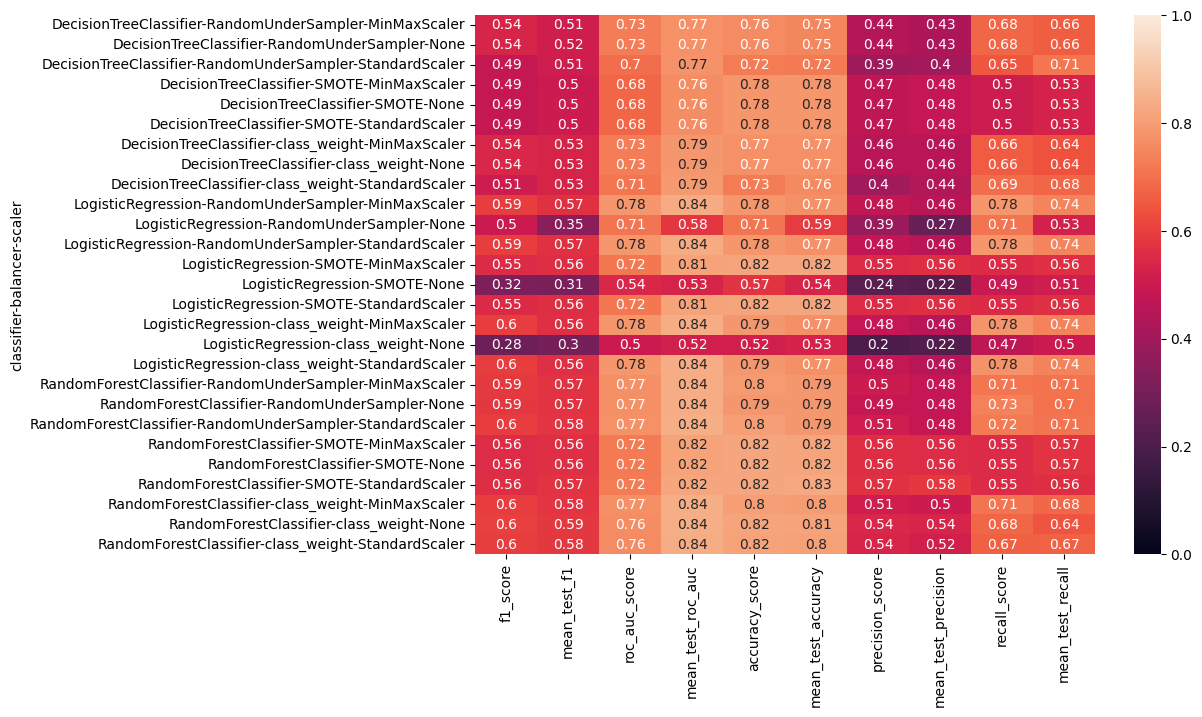

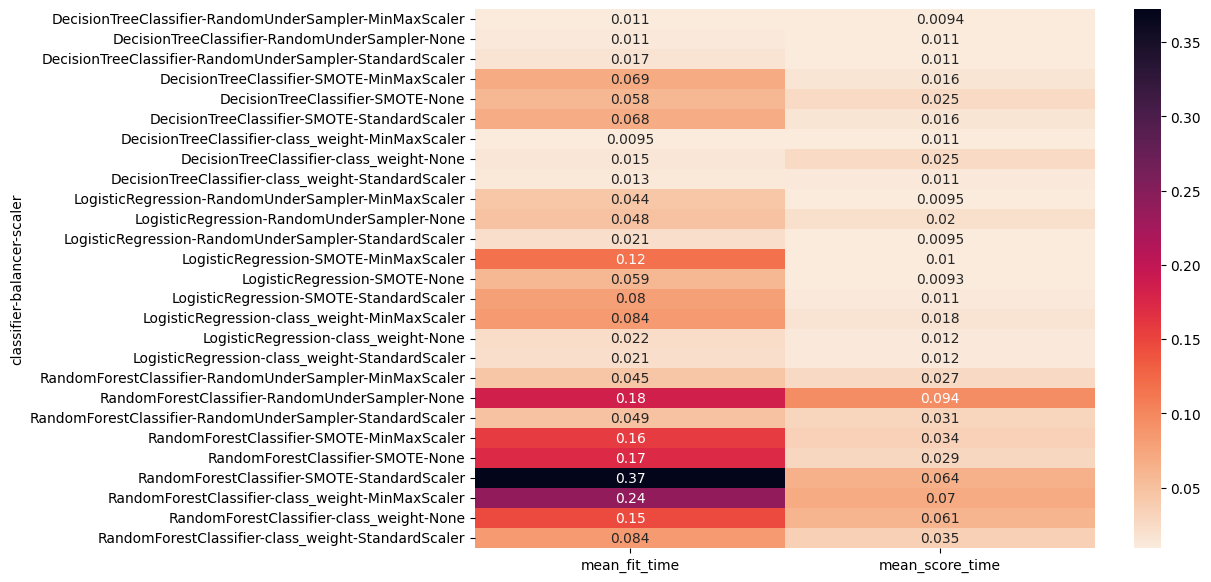

mean_fit_time  \
classifier             balancer           scaler                          
DecisionTreeClassifier RandomUnderSampler MinMaxScaler         0.010688   
                                          None                 0.011172   
                                          StandardScaler       0.016598   
                       SMOTE              MinMaxScaler         0.069358   
                                          None                 0.058003   
                                          StandardScaler       0.068327   
                       class_weight       MinMaxScaler         0.009476   
                                          None                 0.014763   
                                          StandardScaler       0.012723   
LogisticRegression     RandomUnderSampler MinMaxScaler         0.044281   
                                          None                 0.047646   
                                          StandardScaler       0.021247   
                       SMOTE              MinMaxScaler         0.117187   
                                          None                 0.058643   
                                          StandardScaler       0.079971   
                       class_weight       MinMaxScaler         0.083825   
                                          None                 0.022204   
                                          StandardScaler       0.020725   
RandomForestClassifier RandomUnderSampler MinMaxScaler         0.045483   
                                          None                 0.184773   
                                          StandardScaler       0.048938   
                       SMOTE              MinMaxScaler         0.157063   
                                          None                 0.173373   
                                          StandardScaler       0.372088   
                       class_weight       MinMaxScaler         0.239922   
                                          None                 0.145441   
                                          StandardScaler       0.083543   

                                                          mean_score_time  
classifier             balancer           scaler                           
DecisionTreeClassifier RandomUnderSampler MinMaxScaler           0.009369  
                                          None                   0.010550  
                                          StandardScaler         0.010717  
                       SMOTE              MinMaxScaler           0.016157  
                                          None                   0.024934  
                                          StandardScaler         0.015660  
                       class_weight       MinMaxScaler           0.010517  
                                          None                   0.025454  
                                          StandardScaler         0.010918  
LogisticRegression     RandomUnderSampler MinMaxScaler           0.009491  
                                          None                   0.020284  
                                          StandardScaler         0.009491  
                       SMOTE              MinMaxScaler           0.010307  
                                          None                   0.009324  
                                          StandardScaler         0.010871  
                       class_weight       MinMaxScaler           0.017727  
                                          None                   0.011977  
                                          StandardScaler         0.011639  
RandomForestClassifier RandomUnderSampler MinMaxScaler           0.027133  
                                          None                   0.094441  
                                          StandardScaler         0.030515  
                       SMOTE              MinMaxScaler           0.034331  
                                          None            

In [31]:
score_matrix(logBestParams_df2_f1)
time_matrix(logBestParams_df2_f1)

Para as novas variáveis consideradas neste modelo, o `LogisticRegression` passou a performar bem comparado ao teste anterior. Faremos uma análise de seus resultados utilizando `RandomUnderSampler` e `MinMaxScaler`.

In [32]:
# Gerando o modelo
modelo2 = Modelo(df2)
modelo2.gerar_modelo(balancer='RandomUnderSampler', scaler='MinMaxScaler', classifier='LogisticRegression', refit='f1')

C:\Users\lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_search.py:305: UserWarning: The total space of parameters 7 is smaller than n_iter=10. Running 7 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
C:\Users\lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\lucas\AppData\Local\Packages\PythonSoftwareFound

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=31, shuffle=True),
                   estimator=Pipeline(steps=[('balancer',
                                              RandomUnderSampler(random_state=31)),
                                             ('scaler', MinMaxScaler()),
                                             ('classifier',
                                              LogisticRegression(class_weight='balanced',
                                                                 random_state=31))]),
                   param_distributions={'classifier__C': [0.001, 0.01, 0.1, 1,
                                                          10, 100, 1000]},
                   refit='f1',
                   scoring=('f1', 'roc_auc', 'accuracy', 'precision', 'recall'))

In [33]:
# Métricas do Cross-Validation
display(pd.DataFrame(modelo2.cv_results))

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__C,params,split0_test_f1,split1_test_f1,split2_test_f1,split3_test_f1,...,split1_test_recall,split2_test_recall,split3_test_recall,split4_test_recall,mean_test_recall,std_test_recall,rank_test_recall,balancer,scaler,classifier
0,0.028609,0.005329,0.016040,0.002006,0.001,{'classifier__C': 0.001},0.500000,0.468864,0.524934,0.524548,...,0.673684,0.701754,0.712281,0.702797,0.704770,0.019244,7,RandomUnderSampler,MinMaxScaler,LogisticRegression
1,0.029088,0.007156,0.017232,0.004648,0.01,{'classifier__C': 0.01},0.517879,0.498741,0.536585,0.547145,...,0.694737,0.694737,0.722807,0.699301,0.709685,0.017114,6,RandomUnderSampler,MinMaxScaler,LogisticRegression
2,0.025262,0.001461,0.010919,0.000753,0.1,{'classifier__C': 0.1},0.550649,0.521053,0.567493,0.582173,...,0.694737,0.722807,0.733333,0.723776,0.723703,0.016364,5,RandomUnderSampler,MinMaxScaler,LogisticRegression
3,0.057178,0.012846,0.020984,0.012687,1,{'classifier__C': 1},0.558630,0.536398,0.571429,0.568681,...,0.736842,0.743860,0.726316,0.755245,0.741224,0.009507,4,RandomUnderSampler,MinMaxScaler,LogisticRegression
4,0.094519,0.043839,0.015631,0.002438,10,{'classifier__C': 10},0.551724,0.550576,0.566802,0.582069,...,0.754386,0.736842,0.740351,0.755245,0.743330,0.009976,1,RandomUnderSampler,MinMaxScaler,LogisticRegression
5,0.057018,0.008369,0.012996,0.001823,100,{'classifier__C': 100},0.552000,0.551990,0.563342,0.581717,...,0.754386,0.733333,0.736842,0.758741,0.741924,0.012501,3,RandomUnderSampler,MinMaxScaler,LogisticRegression
6,0.057129,0.006821,0.011954,0.002375,1000,{'classifier__C': 1000},0.553928,0.551990,0.562584,0.581717,...,0.754386,0.733333,0.736842,0.758741,0.742625,0.011676,2,RandomUnderSampler,MinMaxScaler,LogisticRegression


In [37]:
# Melhores hiperparâmetros e métricas no conjunto de teste
display(modelo1.best_params_)
display(modelo1.scores)

{'classifier__n_estimators': 50,
 'classifier__max_features': 'log2',
 'classifier__max_depth': 8,
 'classifier__criterion': 'gini'}

,f1_score,roc_auc_score,accuracy_score,precision_score,recall_score
0,0.628062,0.780645,0.833,0.574728,0.692308


In [34]:
# Melhores hiperparâmetros e métricas no conjunto de teste
display(modelo2.best_params_)
display(modelo2.scores)

{'classifier__C': 1000}

,f1_score,roc_auc_score,accuracy_score,precision_score,recall_score
0,0.594662,0.782939,0.782333,0.479,0.783961


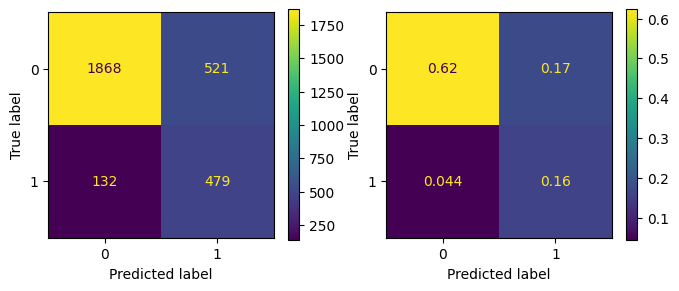

In [35]:
# Matriz de confusão
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))
ConfusionMatrixDisplay(modelo2.cm).plot(ax=ax1)
ConfusionMatrixDisplay(modelo2.cm / modelo2.cm.sum()).plot(ax=ax2)

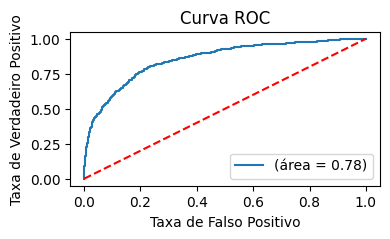

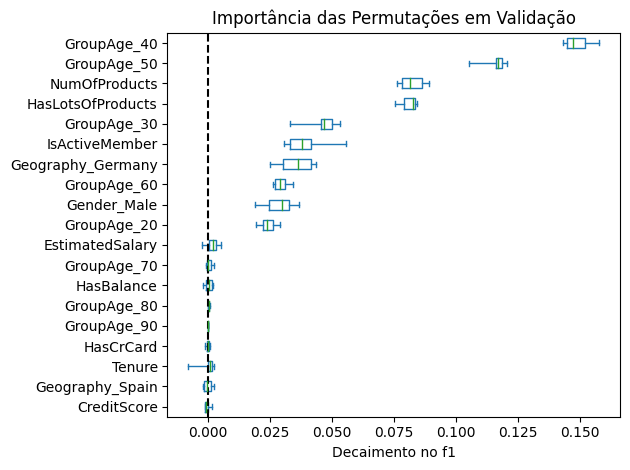

In [36]:
# Curva ROC e importância das variáveis
modelo2.curva_roc()
modelo2.importancia_variaveis()

#### Considerações

Percebemos que o `GroupAge_40` e `GroupAge_50`, foram relevantes para o modelo, indicando que o intervalo de 40~59 anos é tratado de forma mais importante para a caracterização dos resultados.
`NumOfProducts` se manteve importante e `HasLotsOfProducts` também demonstrou parcela de relevância para o modelo.

É interessante notar que o `LogisticRegression` conseguiu gerar resultados equivalentes aos obtidos pelo `RandomForestClassifier` anteriormente. Considerando se trata de um modelo mais rápido para treinar, sua utilização pode ser mais interessante, porém deve ser levado em consideração que seria necessário gastar mais recursos computacionais na etapa de pré-processamento uma vez que algumas colunas de variáveis foram criadas.